In [2]:
import tensorflow as tf
import numpy as np 
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers

## Step 1: Set up the dataset

In [3]:
path = "./different_cards"
img_size = (96, 96)
b_size = 8
train_ds = image_dataset_from_directory(path,
                                       validation_split= 0.2,
                                       subset="training",
                                       shuffle = True,
                                       batch_size = b_size,
                                       seed = 321,
                                       image_size = img_size)

val_ds = image_dataset_from_directory(path,
                                     validation_split= 0.2,
                                     subset="validation",
                                     shuffle = True,
                                     batch_size = b_size,
                                     seed = 321,
                                     image_size = img_size)


Found 128 files belonging to 3 classes.
Using 103 files for training.
Found 128 files belonging to 3 classes.
Using 25 files for validation.


In [4]:
class_names = train_ds.class_names
print(class_names)

['arts', 'buster', 'quick']


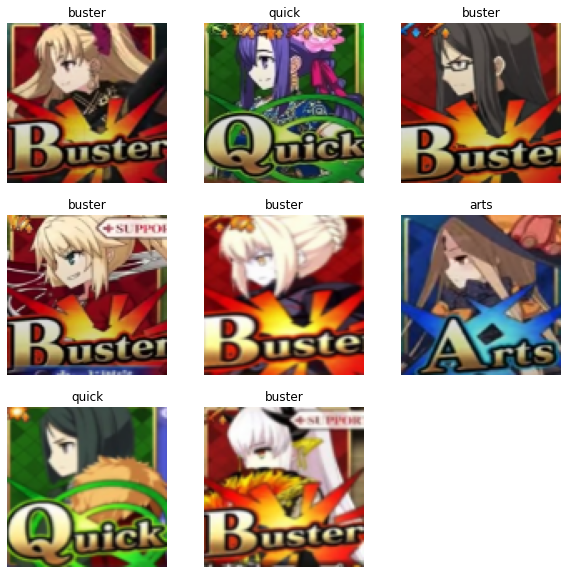

In [10]:
# helper function for data visualization 

def plot_ds(dataset, num = 8, rows = 3, columns = 3):
    if num > 9: 
        print("warning: plot num images <= 9, defaulting to 9")
        num = 9
    plt.figure(figsize=(10,10))
    for imgs, labels in dataset.take(1):
        for i in range(num):
            ax = plt.subplot(rows, columns, i+1)
            plt.imshow(imgs[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

plot_ds(train_ds, 8, 3, 3)

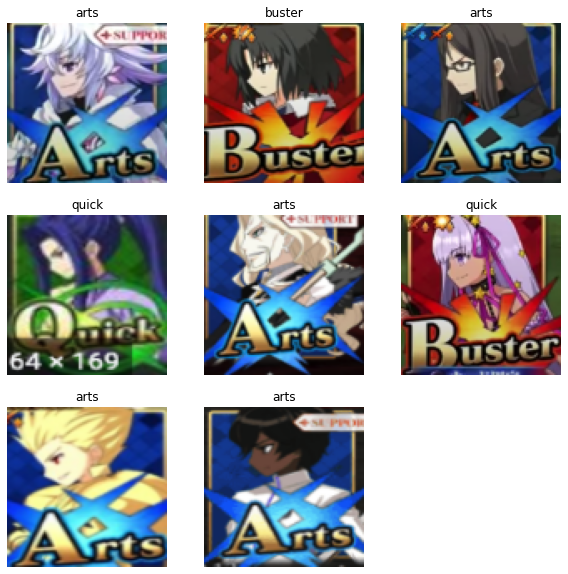

In [11]:
plot_ds(val_ds)

In [13]:
# check the shape of the batches from the dataset

for image_batch, label_batch in train_ds:
    print(image_batch.shape)
    print(label_batch.shape)
    break
    
# check what form the labels are encoded in
print(label_batch)

(8, 96, 96, 3)
(8,)
tf.Tensor([1 2 2 0 0 0 2 2], shape=(8,), dtype=int32)


## Step 2: Set up the Model

In [21]:
# we just need to define a normalization layer that rescales rgb values from 0-255 to 0-1, which will be added later
norm_layer = layers.experimental.preprocessing.Rescaling(1./255)

# note: in this particular case augmentation doesn't help us since the cards will always be the same orientation

# add rgb dimension for input size 
input_size = img_size + (3,)

# set up the pre-trained model 
base_cnn = tf.keras.applications.ResNet50(input_shape = input_size,
                                         include_top = False,
                                         weights = 'imagenet')

# for the initial run, lets freeze the base_cnn
base_cnn.trainable = False

In [22]:
# lets check what our base cnn does to an input batch

image_batch, label_batch = next(iter(train_ds))
feature_batch = base_cnn(image_batch)

print("feature batch shape: ", feature_batch.shape)

feature batch shape:  (8, 3, 3, 2048)


In [23]:
# so we get 2048 3x3 features, which we need to flatten or average up for a dense network
# like a flatten layer but instead of just literally flattening it takes the average
global_avg_layer = layers.GlobalAveragePooling2D() 

# check shape of the output of flattening
fb_avg = global_avg_layer(feature_batch)
print("flattened shape: ", fb_avg.shape)


flattened shape:  (8, 2048)


In [24]:
# set up a simple dense network, with 3 classes
prediction_layer = tf.keras.Sequential([layers.Dense(2048, activation="relu"), 
                                        layers.Dense(2048, activation="relu"),
                                        layers.Dense(3, activation="softmax")])

pred_batch = prediction_layer(fb_avg)
print("prediction shape: ", pred_batch.shape)
print("predictions: ", pred_batch)

prediction shape:  (8, 3)
predictions:  tf.Tensor(
[[0.25758436 0.12743884 0.61497676]
 [0.18027835 0.08668777 0.7330339 ]
 [0.17564273 0.09958071 0.72477657]
 [0.1579591  0.11676465 0.72527623]
 [0.28127503 0.25874498 0.45997998]
 [0.49166545 0.10679179 0.40154275]
 [0.07044823 0.1243595  0.80519223]
 [0.07712617 0.06713891 0.8557349 ]], shape=(8, 3), dtype=float32)


In [25]:
# build the actual model, but chaining together inputs and outputs

inputs = tf.keras.Input(shape=input_size)
x = norm_layer(inputs)
x = base_cnn(x, training=False) # setting training to false is important because of batch norm stuff
x = global_avg_layer(x)
outputs = prediction_layer(x)

model = tf.keras.Model(inputs, outputs)

base_lr = 1e-4 
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_lr),
             loss=tf.keras.losses.SparseCategoricalCrossentropy(),
             metrics=['accuracy'])

model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 96, 96, 3)         0         
_________________________________________________________________
resnet50 (Functional)        (None, 3, 3, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 3)                 8398851   
Total params: 31,986,563
Trainable params: 8,398,851
Non-trainable params: 23,587,712
_________________________________________________________________


## Step 3: transfer learning and fine tuning

In [26]:
# helper function for using fit directly with epoch and a simple call back 
restoring_cb = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                               patience=5,
                                               restore_best_weights=True)

def train_model_basic(model, cbs, epochs, train_ds, val_ds):
    history = model.fit(train_ds,
                       epochs=epochs,
                       validation_data = val_ds,
                       callbacks = cbs)
    
    return history 


In [28]:
history = train_model_basic(model, [restoring_cb], 10, train_ds, val_ds)

Epoch 1/10
13/13 [==============================] - 2s 166ms/step - loss: 0.9238 - accuracy: 0.7379 - val_loss: 0.9666 - val_accuracy: 0.6400
Epoch 2/10
13/13 [==============================] - 2s 165ms/step - loss: 0.8926 - accuracy: 0.6311 - val_loss: 0.8599 - val_accuracy: 0.6800
Epoch 3/10
13/13 [==============================] - 2s 161ms/step - loss: 0.8418 - accuracy: 0.7184 - val_loss: 0.8661 - val_accuracy: 0.6400
Epoch 4/10
13/13 [==============================] - 2s 167ms/step - loss: 0.7986 - accuracy: 0.7087 - val_loss: 0.8313 - val_accuracy: 0.4800
Epoch 5/10
13/13 [==============================] - 2s 161ms/step - loss: 0.7656 - accuracy: 0.7476 - val_loss: 0.8405 - val_accuracy: 0.6400
Epoch 6/10
13/13 [==============================] - 2s 172ms/step - loss: 0.6899 - accuracy: 0.7864 - val_loss: 0.7149 - val_accuracy: 0.8400
Epoch 7/10
13/13 [==============================] - 2s 165ms/step - loss: 0.6693 - accuracy: 0.7670 - val_loss: 0.7291 - val_accuracy: 0.6800
Epoch 

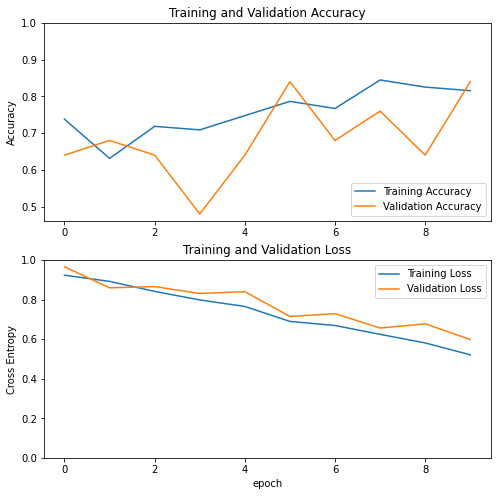

In [29]:
# helper function to check history by plotting loss and acc

def plot_acc_and_loss(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()
    
plot_acc_and_loss(history)

In [30]:
# helper function for fine-tuning 
def fine_tune_model(model, pretrained_index, cbs, epochs, train_ds, val_ds, lr=1e-5):
    model.layers[pretrained_index].trainable = True
    model.compile(optimizer=tf.keras.optimizers.Adam(lr),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    history = train_model_basic(model, cbs, epochs, train_ds, val_ds)
    return history
    

In [33]:
fine_tune_model(model, 2, [restoring_cb], 10, train_ds, val_ds)

Epoch 1/10
13/13 [==============================] - 7s 532ms/step - loss: 0.1666 - accuracy: 0.9612 - val_loss: 0.2386 - val_accuracy: 0.9600
Epoch 2/10
13/13 [==============================] - 6s 485ms/step - loss: 0.0410 - accuracy: 0.9903 - val_loss: 0.2503 - val_accuracy: 0.9600
Epoch 3/10
13/13 [==============================] - 6s 479ms/step - loss: 0.1461 - accuracy: 0.9417 - val_loss: 1.0291 - val_accuracy: 0.6000
Epoch 4/10
13/13 [==============================] - 6s 492ms/step - loss: 0.1663 - accuracy: 0.9320 - val_loss: 0.2917 - val_accuracy: 0.9600
Epoch 5/10
13/13 [==============================] - 6s 498ms/step - loss: 0.0225 - accuracy: 1.0000 - val_loss: 0.2367 - val_accuracy: 0.9600
Epoch 6/10
13/13 [==============================] - 6s 496ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.3040 - val_accuracy: 0.9600


## Step 4: check prediction results

In [62]:
# looks like 96 accuracy is what we have right now, lets take a look at the images ourselves 
# helper functions for displaying prediction results

def plot_pred(predictions, batch_size, image_batch,rows=4, cols=4,):
    plt.figure(figsize=(10, 10))
    for i in range(batch_size):
        ax = plt.subplot(rows, cols, i + 1)
        plt.imshow(image_batch[i].astype("uint8"))
        plt.title(class_names[predictions[i]])
        plt.axis("off")
        
def show_preds_batch(dataset, model):
    image_batch, label_batch = dataset.as_numpy_iterator().next()
    predictions = model.predict_on_batch(image_batch)
    predictions = [np.where(x == max(x))[0][0] for x in predictions] # sets index of max confidence as prediction
    print("Predictions: ", predictions)
    plot_pred(predictions, len(predictions), image_batch, 3, 3)

def show_preds_all(dataset, model):
    for images, labels in dataset:
        predictions = model.predict_on_batch(images)
        predictions = [np.where(x == max(x))[0][0] for x in predictions] # sets index of max confidence as prediction
        images = np.array(images)
        plot_pred(predictions, len(predictions), images, 3, 3)

            
        
    

Predictions:  [0, 1, 2, 0, 1, 2, 0, 1]


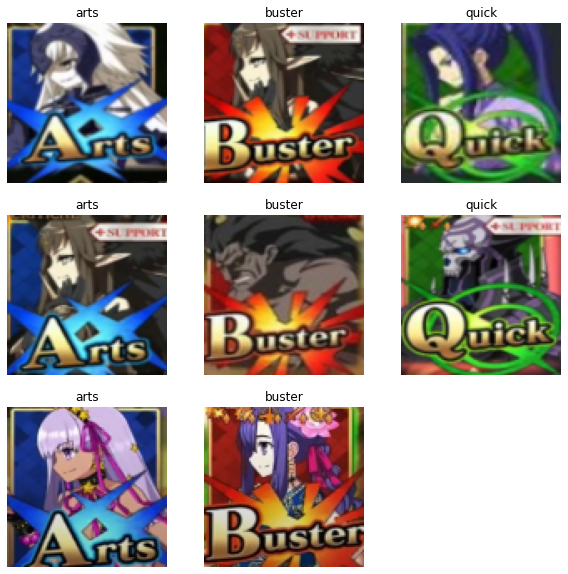

In [63]:
show_preds_batch(train_ds, model)

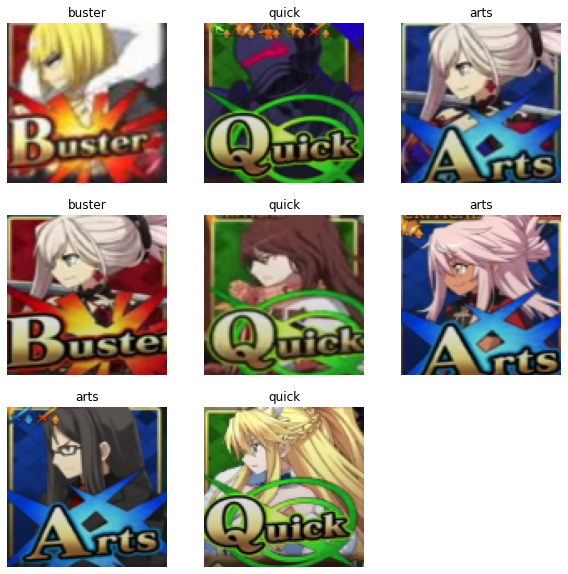

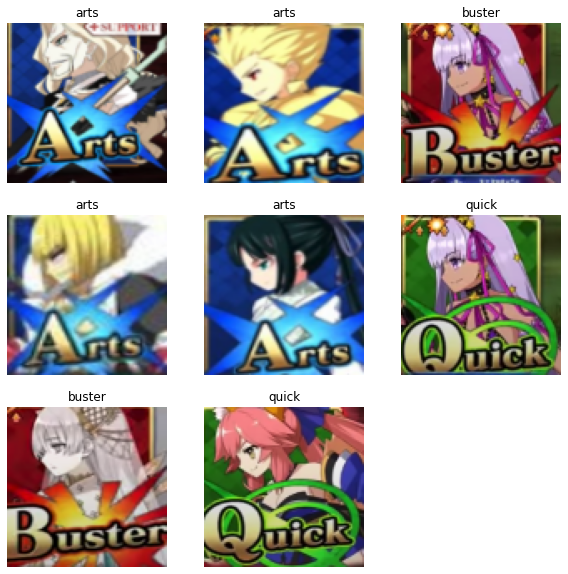

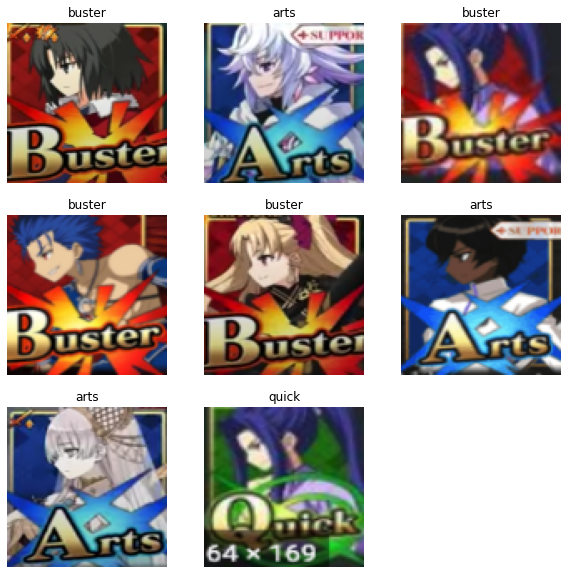

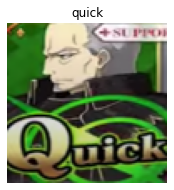

In [64]:
show_preds_all(val_ds, model)

## Step 5: save model 

In [65]:
# save whole model, optimizer, compiler and all 
model.save("backup_card_classifier_model")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: backup_card_classifier_model/assets


In [67]:
# save model architecture to json

json_f = model.to_json()
f = open("backup_card_model.json", "w")
f.write(json_f)
f.close()

model.save_weights("backup_card_model.h5")